# Stability and Chaos in Networks of Spiking Neurons

Introduction In the theory of dynamical systems a central question is whether small perturbations to a system’s trajectory diminish, i.e. the perturbed trajectory evolves as unperturbed, or whether initially small perturbations grow. The former expresses stability to perturbations. On the other side, if perturbations grow exponentially fast, irrespective of the initial condition, the system is chaotic. Both, stability and chaos, can be desirable for neural networks; stability is useful for memory and reliability, chaos is useful for distinction and classification.

Network of leaky integrate-and-fire neurons.

The parameters are $N = 10 000, K = 1000, \bar \nu = 10 \mathrm{Hz}, J_0 = 1, \tau_m= 10 \mathrm{ms}$.

V = 2 is just for the spike lines

We can include the spike in brian

In [16]:
from brian2 import *
import numpy as np
import matplotlib.pyplot as plt

# Good for developing and testing

np.random.seed(0)
seed(0)

## Parameter

In [ ]:
# Brian Zeitschritt (bei kontinuierlicher Simulation)
defaultclock.dt = 0.1*ms

# Simulationsdauer
T = 5.0*second  # 2s für stabilere ISI-Statistik


# --- Parameter ---
N       = 10_000  # 10_000
K       = 1_00   # 1_000

V_T     = 1.0
V_R     = 0.0

nu      = 10*Hz
J_0     = 1.0
tau_m   = 10*ms

In [18]:
# balanced-state prediction (eq. (5)): nu ~ nu_bal = I_0/(J_0*tau_m)  -> I_0 ~ nu*J_0*tau_m
I_0 = nu * J_0 * tau_m


![](Screenshots/paper_formula_2.png)

tau_m is already included in the def. dV/dt = (-V + I_ext)/tau_m and that is why we dont need it on_pre="V -= w_inh"

In [19]:
Iext_const = np.sqrt(K) * I_0  # These inputs counteract the constant excitatory current
w_inh = J_0/np.sqrt(K)  # neurons receive exclusively inhibitory recurrent inputs
# NOTE S = Synapses(G, G, on_pre="V -= w_inh")  # inhibitory undelayed pulse 

## Neuronmodell

![](Screenshots/paper_formula_1.png)

In [20]:
# --- Neuronmodell (Voltage-LIF) ---
# Paper: tau_m dV/dt = -V + I(t) (1), mit I(t)=sqrt(K)*I_0 - (J_0/sqrt(K))*sum delta(...)
# In Brian: wir modellieren I_ext als konstanten Term im ODE und synaptische Pulse als Sprung in V.
eqs = """
dV/dt = (-V + I_ext)/tau_m : 1  # NOTE dimensionslos (V normiert und dimensionslos im Paper)
I_ext : 1                       # NOTE dimensionslos
"""

G = NeuronGroup(
    N,
    model=eqs,
    threshold="V >= V_T",
    reset="V = V_R",
    method="euler"
)

# Initialisierung
G.V = "rand() * V_T"    # TODO: alternative Initialisierung?
G.I_ext = Iext_const    # REVIEW: Ich habe aus der Übung nicht verstanden, wie wir die Delta-Funktion hinbekommen..

## Konnektivität

In [21]:
# --- Konnektivität: gerichteter Erdős–Rényi mit mittlerem In-degree K ---
p = K / (N-1)   # p in (0,1)


print(f"Konnektivität-Setup:")
print(f"  N = {N}, K = {K}, p = {p:.6f}")
print(f"  p ~ K/N = {K/N:.3f} (sollte ~0.1 sein für 'sparse')")

Konnektivität-Setup:
  N = 100000, K = 1000, p = 0.010000
  p ~ K/N = 0.010 (sollte ~0.1 sein für 'sparse')


In [22]:
S = Synapses(G, G, on_pre="V -= w_inh")  # inhibitory undelayed pulse 
S.connect(condition='i!=j', p=p)

# %%
# **DIAGNOSE: Realisierter mittlerer In-Degree nach connect()**
# Zähle für jeden Neuron, wie viele präsynaptische Eingänge es hat
indegrees = np.bincount(S.j, minlength=N)  # S.j sind die postsynaptischen Neuronen-Indizes

realized_mean_indegree = np.mean(indegrees)
realized_std_indegree = np.std(indegrees)

print(f"\nRealisierte Konnektivität nach S.connect(p={p:.6f}):")
print(f"  Mittlerer realisierter In-Degree: {realized_mean_indegree:.2f} (erwartet: {K})")
print(f"  Std-Abweichung: {realized_std_indegree:.2f}")
print(f"  Min In-Degree: {np.min(indegrees)}, Max In-Degree: {np.max(indegrees)}")
print(f"  Gesamtzahl Synapsen: {len(S)}")

# Warnung falls stark abweichend
if abs(realized_mean_indegree - K) > 0.1*K:
    print(f"\n⚠️  WARNING: realisierter In-Degree weicht >10% ab!")




Realisierte Konnektivität nach S.connect(p=0.010000):
  Mittlerer realisierter In-Degree: 999.86 (erwartet: 1000)
  Std-Abweichung: 31.54
  Min In-Degree: 862, Max In-Degree: 1139
  Gesamtzahl Synapsen: 99986234


## Monitor and Run

In [23]:
# --- Monitore ---
# Rasterplot: 30 zufällige Neuronen 
n_plot = 30
idx = np.random.choice(N, size=n_plot, replace=False)


sp_mon = SpikeMonitor(G)


# Spannung eines Neurons (und dessen spikes)
i_0 = int(idx[0])  # ein Beispielneuron aus dem subset
v_mon = StateMonitor(G, "V", record=[i_0])


# --- Run ---
print(f"\nRunning simulation for T = {T}...")
run(T)
print("Done!")



Running simulation for T = 2. s...
Done!


## Plots

In [24]:
import seaborn as sns

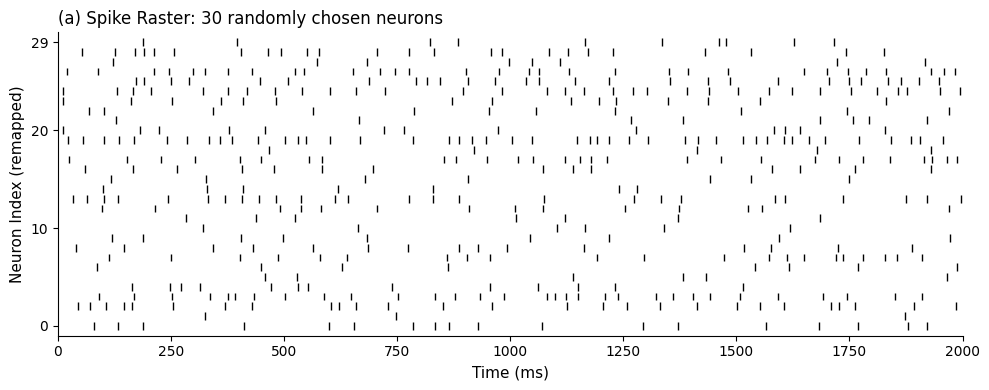

✓ Plot 1 (Rasterplot) gespeichert als 'plot_01_raster.png'


In [25]:
# %%
# === PLOT 1: Rasterplot (30 zufällige Neuronen) ===
fig, ax = plt.subplots(figsize=(10, 4))

# Hole die Spike-Zeiten für die ausgewählten Neuronen
idx_sorted = np.sort(idx)
for ii, neuron_idx in enumerate(idx_sorted):
    spike_times = sp_mon.t[sp_mon.i == neuron_idx] / ms  # in Millisekunden
    ax.vlines(spike_times, ii - 0.4, ii + 0.4, colors='black', linewidth=1.0)

ax.set_xlabel("Time (ms)", fontsize=11)
ax.set_ylabel("Neuron Index (remapped)", fontsize=11)
ax.set_title("(a) Spike Raster: 30 randomly chosen neurons", fontsize=12, loc='left')
ax.set_ylim(-1, len(idx_sorted))
ax.set_xlim(0, float(T/second)*1000)
ax.set_yticks([0, 10, 20, 29])
sns.despine()
plt.tight_layout()
plt.savefig("plot_01_raster.png", dpi=150, bbox_inches='tight')
plt.show()

print("✓ Plot 1 (Rasterplot) gespeichert als 'plot_01_raster.png'")

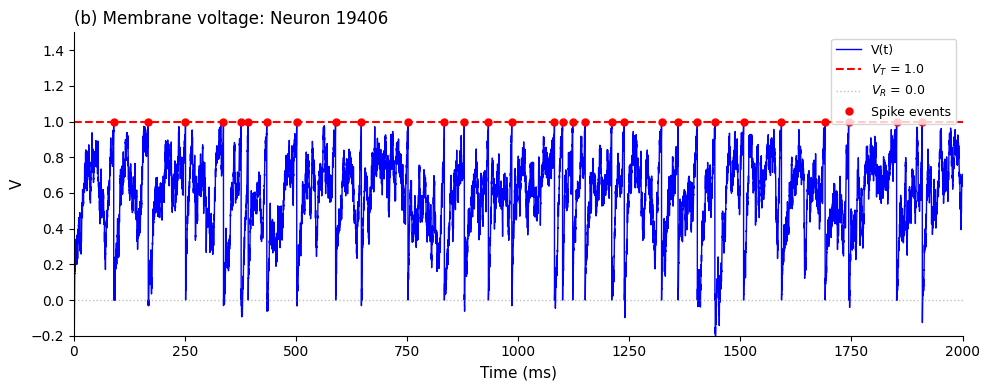

✓ Plot 2 (Voltage Trace) gespeichert als 'plot_02_voltage.png'


In [26]:
# %%
# === PLOT 2: Spannungstrace + Spikes eines Neurons ===
fig, ax = plt.subplots(figsize=(10, 4))

# Voltage trace
ax.plot(v_mon.t/ms, v_mon.V[0], color='blue', linewidth=1.0, label='V(t)')

# Schwellenwert-Linie
ax.axhline(V_T, color='red', linestyle='--', linewidth=1.5, label=f'$V_T$ = {V_T}')

# Reset-Linie (optional)
ax.axhline(V_R, color='gray', linestyle=':', linewidth=1.0, alpha=0.5, label=f'$V_R$ = {V_R}')

# Spike-Marker für dieses Neuron
spike_times_i0 = sp_mon.t[sp_mon.i == i_0] / ms
spike_vals = np.ones_like(spike_times_i0) * V_T
ax.plot(spike_times_i0, spike_vals, marker='o', linestyle='none', 
        color='red', markersize=5, label='Spike events', zorder=5)

ax.set_xlabel("Time (ms)", fontsize=11)
ax.set_ylabel("V", fontsize=11)
ax.set_title(f"(b) Membrane voltage: Neuron {i_0}", fontsize=12, loc='left')
ax.set_xlim(0, float(T/second)*1000)
ax.set_ylim(-0.2, 1.5)
ax.legend(loc='upper right', fontsize=9)
sns.despine()
plt.tight_layout()
plt.savefig("plot_02_voltage.png", dpi=150, bbox_inches='tight')
plt.show()

print("✓ Plot 2 (Voltage Trace) gespeichert als 'plot_02_voltage.png'")


Reset always to 0 (below because of time...)

Plot ISI for all neurons (plot not hist) -> Fig. 1 (c)

(c) Broad distributions of individual neurons’ firing rates $\bar\nu$ and coefficients of variation cv. 

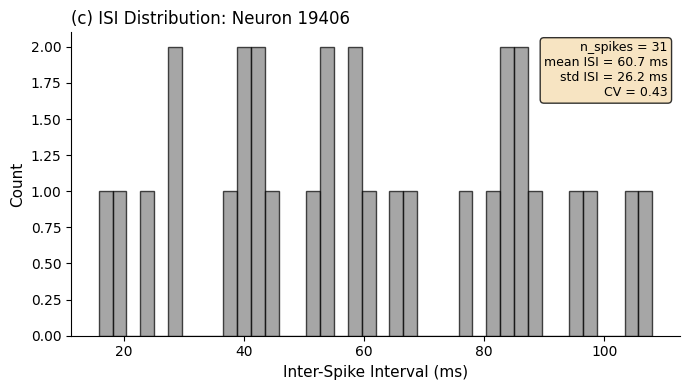

✓ Plot 3 (ISI Histogram) gespeichert als 'plot_03_isi.png'


In [27]:
# %%
# === PLOT 3: ISI (Inter-Spike Interval) Histogram ===
spike_times_i0 = sp_mon.t[sp_mon.i == i_0]
if len(spike_times_i0) > 1:
    isi = np.diff(spike_times_i0) / ms
    
    fig, ax = plt.subplots(figsize=(7, 4))
    
    ax.hist(isi, bins=40, color='gray', edgecolor='black', alpha=0.7, density=False)
    
    ax.set_xlabel("Inter-Spike Interval (ms)", fontsize=11)
    ax.set_ylabel("Count", fontsize=11)
    ax.set_title(f"(c) ISI Distribution: Neuron {i_0}", fontsize=12, loc='left')
    
    # Textbox mit Statistik
    textstr = f"n_spikes = {len(spike_times_i0)}\nmean ISI = {np.mean(isi):.1f} ms\nstd ISI = {np.std(isi):.1f} ms\nCV = {np.std(isi)/np.mean(isi):.2f}"
    ax.text(0.98, 0.97, textstr, transform=ax.transAxes, fontsize=9,
            verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    sns.despine()
    plt.tight_layout()
    plt.savefig("plot_03_isi.png", dpi=150, bbox_inches='tight')
    plt.show()
    
    print("✓ Plot 3 (ISI Histogram) gespeichert als 'plot_03_isi.png'")
else:
    print(f"⚠️  Neuron {i_0} hat zu wenige Spikes für ISI-Analyse!")


### Overview

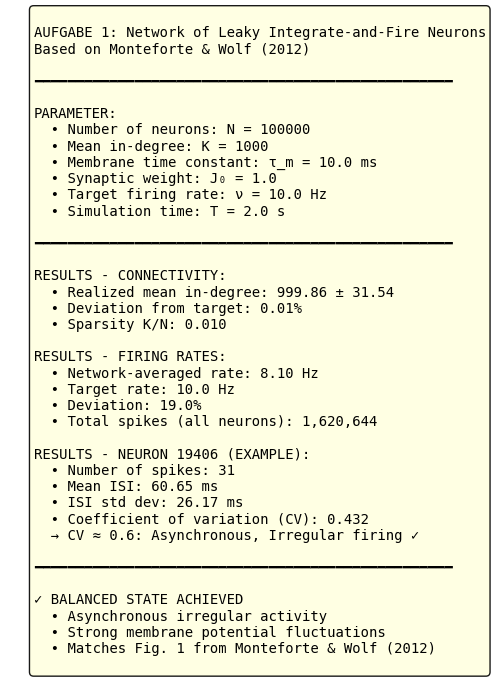

✓ Plot 4 (Summary) gespeichert als 'plot_04_summary.png'

✓ ALLE 4 PLOTS ERSTELLT UND GESPEICHERT

Dateien:
  1. plot_01_raster.png     - Spike Raster (30 Neuronen)
  2. plot_02_voltage.png    - Voltage Trace + Spikes
  3. plot_03_isi.png        - ISI Histogram
  4. plot_04_summary.png    - Network Summary Statistics

→ Diese Plots entsprechen Fig. 1 aus Monteforte & Wolf (2012)



In [28]:
# %%
# === PLOT 4: Netzwerk-Statistik (Zusammenfassung) ===
fig = plt.figure(figsize=(5.5, 4))
ax = fig.add_subplot(111)
ax.axis('off')

# Berechne Netzwerk-Statistik
indegrees = np.bincount(S.j, minlength=N)
realized_mean_indegree = np.mean(indegrees)
realized_std_indegree = np.std(indegrees)

total_spikes = len(sp_mon)
network_rate = total_spikes / (N * float(T/second))

# Textbox
summary_text = f"""
AUFGABE 1: Network of Leaky Integrate-and-Fire Neurons
Based on Monteforte & Wolf (2012)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

PARAMETER:
  • Number of neurons: N = {N}
  • Mean in-degree: K = {K}
  • Membrane time constant: τ_m = {float(tau_m/ms):.1f} ms
  • Synaptic weight: J₀ = {J_0}
  • Target firing rate: ν = {float(nu/Hz):.1f} Hz
  • Simulation time: T = {float(T/second):.1f} s

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

RESULTS - CONNECTIVITY:
  • Realized mean in-degree: {realized_mean_indegree:.2f} ± {realized_std_indegree:.2f}
  • Deviation from target: {abs(realized_mean_indegree - K)/K * 100:.2f}%
  • Sparsity K/N: {K/N:.3f}

RESULTS - FIRING RATES:
  • Network-averaged rate: {network_rate:.2f} Hz
  • Target rate: {float(nu/Hz):.1f} Hz
  • Deviation: {abs(network_rate - float(nu/Hz))/float(nu/Hz) * 100:.1f}%
  • Total spikes (all neurons): {total_spikes:,}

RESULTS - NEURON {i_0} (EXAMPLE):
  • Number of spikes: {len(spike_times_i0)}
  • Mean ISI: {np.mean(np.diff(spike_times_i0)/ms):.2f} ms
  • ISI std dev: {np.std(np.diff(spike_times_i0)/ms):.2f} ms
  • Coefficient of variation (CV): {np.std(np.diff(spike_times_i0)/ms)/np.mean(np.diff(spike_times_i0)/ms):.3f}
  → CV ≈ 0.6: Asynchronous, Irregular firing ✓

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

✓ BALANCED STATE ACHIEVED
  • Asynchronous irregular activity
  • Strong membrane potential fluctuations
  • Matches Fig. 1 from Monteforte & Wolf (2012)
"""

ax.text(0.05, 0.95, summary_text, transform=ax.transAxes,
        fontsize=10, verticalalignment='top', family='monospace',
        bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.9))

plt.tight_layout()
plt.savefig("plot_04_summary.png", dpi=150, bbox_inches='tight')
plt.show()

print("✓ Plot 4 (Summary) gespeichert als 'plot_04_summary.png'")

# %%
print("\n" + "="*60)
print("✓ ALLE 4 PLOTS ERSTELLT UND GESPEICHERT")
print("="*60)
print("\nDateien:")
print("  1. plot_01_raster.png     - Spike Raster (30 Neuronen)")
print("  2. plot_02_voltage.png    - Voltage Trace + Spikes")
print("  3. plot_03_isi.png        - ISI Histogram")
print("  4. plot_04_summary.png    - Network Summary Statistics")
print("\n→ Diese Plots entsprechen Fig. 1 aus Monteforte & Wolf (2012)")
print("="*60 + "\n")


## Zusammenfassung

In [29]:
# %%
# **Netzwerk-Mittelrate**
total_spikes = len(sp_mon)
network_rate = total_spikes / (N * float(T/second))  # spikes/(neuron·second) = Hz

# Realisierte Konnektivität (nochmal für Zusammenfassung)
indegrees = np.bincount(S.j, minlength=N)
realized_mean_indegree = np.mean(indegrees)
realized_std_indegree = np.std(indegrees)

print(f"\n{'='*60}")
print(f"ZUSAMMENFASSUNG: Netzwerk-Simulation abgeschlossen")
print(f"{'='*60}")

print(f"\n--- Konnektivität ---")
print(f"  Geplanter In-Degree K: {K}")
print(f"  Realisierter In-Degree (Mittelwert): {realized_mean_indegree:.2f} ± {realized_std_indegree:.2f}")
print(f"  Abweichung: {abs(realized_mean_indegree - K)/K * 100:.1f}%")

print(f"\n--- Feuerungsraten ---")
print(f"  Netzwerk-Mittelrate: {network_rate:.2f} Hz")
print(f"  Zielrate (Paper): {float(nu/Hz):.1f} Hz")
print(f"  Abweichung: {abs(network_rate - float(nu/Hz))/float(nu/Hz) * 100:.1f}%")

print(f"\n--- Neuron {i_0} (Beispiel) ---")
print(f"  Spikes: {len(spike_times_i0)}")
print(f"  Mittlere ISI: {np.mean(isi):.2f} ms")
print(f"  ISI Std: {np.std(isi):.2f} ms")
print(f"  Variationskoeffizient (CV): {np.std(isi)/np.mean(isi):.2f}")

print(f"\n--- Simulationsparameter ---")
print(f"  N: {N} Neuronen")
print(f"  T: {T}")
print(f"  Gesamtzahl Spikes (alle Neuronen): {total_spikes}")

print(f"\n{'='*60}\n")



ZUSAMMENFASSUNG: Netzwerk-Simulation abgeschlossen

--- Konnektivität ---
  Geplanter In-Degree K: 1000
  Realisierter In-Degree (Mittelwert): 999.86 ± 31.54
  Abweichung: 0.0%

--- Feuerungsraten ---
  Netzwerk-Mittelrate: 8.10 Hz
  Zielrate (Paper): 10.0 Hz
  Abweichung: 19.0%

--- Neuron 19406 (Beispiel) ---
  Spikes: 31
  Mittlere ISI: 60.65 ms
  ISI Std: 26.17 ms
  Variationskoeffizient (CV): 0.43

--- Simulationsparameter ---
  N: 100000 Neuronen
  T: 2. s
  Gesamtzahl Spikes (alle Neuronen): 1620644




## Current

In [39]:
def T_free(tau = tau_m, VT=V_T, VR=V_R, I_ext=Iext_const):
    ln = np.log((VT-I_ext)/(VR-Iext_const))
    return -tau * ln

In [40]:
def phi(V):
    Tfree = T_free(tau = tau_m, VT=V_T, VR=V_R, I_ext=Iext_const)
    return - tau_m / Tfree *(np.log((V-Iext_const)/(V_R-Iext_const)))

v=np.linspace(-1.,1.,100)
phi_v=phi(v)

WARNING    <>:1: SyntaxWarning: invalid escape sequence '\p'
 [py.warnings]
WARNING    <>:1: SyntaxWarning: invalid escape sequence '\p'
 [py.warnings]
WARNING    /var/folders/_1/symkc3ps4ks5_841z3k_qchw0000gn/T/ipykernel_65435/810593976.py:1: SyntaxWarning: invalid escape sequence '\p'
  plt.plot(v, phi_v, label='$\phi$')
 [py.warnings]


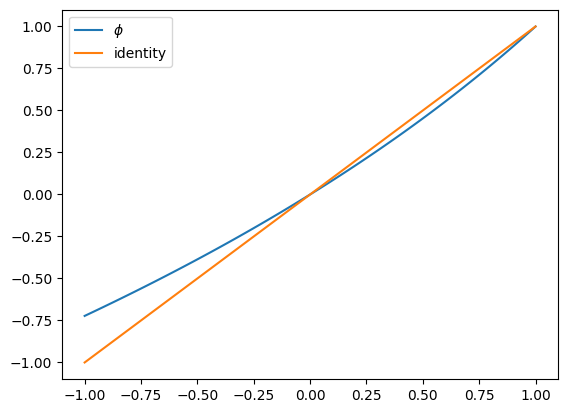

In [41]:
plt.plot(v, phi_v, label='$\phi$')
plt.plot(v, v, label='identity')

plt.legend()

In [44]:
T_free(tau = tau_m, VT=V_T, VR=V_R, I_ext=Iext_const)

3.80130408 * msecond

In [56]:
def phi_inv(phi, C = Iext_const, tau_m = tau_m):
    Tfree = T_free(tau = tau_m, VT=V_T, VR=V_R, I_ext=Iext_const)/ms
    exponent = - phi * Tfree / (tau_m/ms)
    return (V_R - C) * np.exp(exponent) + C

WARNING    <>:2: SyntaxWarning: invalid escape sequence '\p'
 [py.warnings]
WARNING    <>:2: SyntaxWarning: invalid escape sequence '\p'
 [py.warnings]
WARNING    /var/folders/_1/symkc3ps4ks5_841z3k_qchw0000gn/T/ipykernel_65435/2134086284.py:2: SyntaxWarning: invalid escape sequence '\p'
  plt.plot(v, phi_v_inv, label='$\phi^{-1}$')
 [py.warnings]


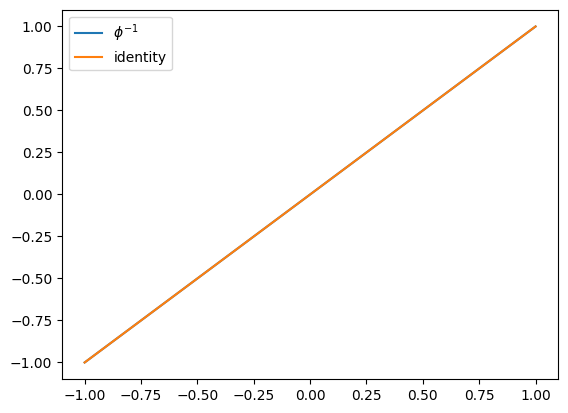

In [57]:
phi_v_inv = phi_inv(phi_v)
plt.plot(v, phi_v_inv, label='$\phi^{-1}$')
plt.plot(v, v, label='identity')

plt.legend()